# Sentiment Analysis Amazon Reviews - Classificazione a 2 Classi

Questo notebook implementa un sistema di sentiment analysis per recensioni Amazon utilizzando una classificazione binaria (negativo, positivo). Vengono confrontati diversi approcci: rule-based (VADER), machine learning tradizionale (TF-IDF + Logistic Regression) e modelli generativi (Gemini).

## Setup Iniziale: Caricamento Dataset e Preparazione Dati

In [13]:
from datasets import load_dataset

# ====================== Data Loading ======================
# Etichette: 0 = NEG, 1 = POS
ds = load_dataset("mteb/amazon_polarity")

TRAIN_FRAC = 0.1
TEST_FRAC  = 0.05
SEED = 42

train_sub = ds["train"].train_test_split(train_size=TRAIN_FRAC, seed=SEED)["train"]
test_sub  = ds["test"].train_test_split(train_size=TEST_FRAC,  seed=SEED)["train"]

train = train_sub.to_pandas()[["text", "label"]].rename(columns={"label":"y"}).dropna()
test  = test_sub.to_pandas()[["text", "label"]].rename(columns={"label":"y"}).dropna()
print("Train size:", len(train), "| Test size:", len(test))


Train size: 359999 | Test size: 20000


## Definizione delle Funzioni di Valutazione

Queste funzioni ci permetteranno di valutare le performance dei diversi modelli in modo consistente, calcolando accuracy, F1-score e visualizzando la matrice di confusione.

In [14]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import numpy as np


LABELS = [0, 1]  # 0=NEG, 1=POS
LABEL2TXT = {0:"NEG", 1:"POS"}

def evaluate_predictions(y_true: list[int], y_pred: list[int], title: str = "Model"):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    print(f"\n=== {title} ===")
    print("Accuracy:", round(acc, 4))
    print("F1-macro:", round(f1, 4))
    print(classification_report(y_true, y_pred, digits=3))
    plot_confusion_matrix(y_true, y_pred, labels=LABELS, title=f"{title} — Confusion Matrix")

def plot_confusion_matrix(y_true, y_pred, labels=LABELS, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(labels))); ax.set_xticklabels([LABEL2TXT[l] for l in labels], rotation=0)
    ax.set_yticks(np.arange(len(labels))); ax.set_yticklabels([LABEL2TXT[l] for l in labels])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.show()

## Modello 1: VADER Sentiment Analysis

**VADER** (Valence Aware Dictionary and sEntiment Reasoner) è un approccio rule-based che utilizza un dizionario lessicale specificamente progettato per l'analisi del sentiment nei social media. È particolarmente efficace per testi informali e può gestire intensificatori, negazioni e punteggiatura enfatica.


=== VADER ===
Accuracy: 0.7198
F1-macro: 0.7086
              precision    recall  f1-score   support

           0      0.870     0.521     0.652     10065
           1      0.655     0.921     0.766      9935

    accuracy                          0.720     20000
   macro avg      0.763     0.721     0.709     20000
weighted avg      0.763     0.720     0.708     20000



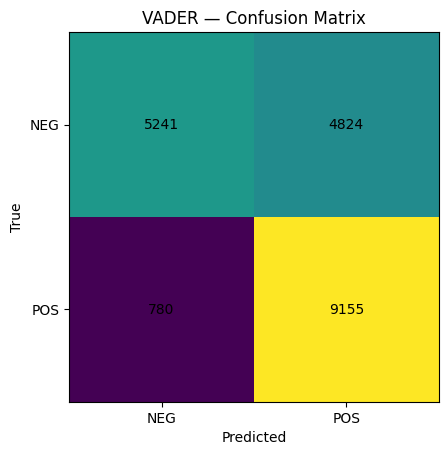

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def vader_predict(texts: list[str]) -> list[int]:
    preds = []
    for t in texts:
        s = sia.polarity_scores(t)["compound"]
        preds.append(1 if s >= 0.05 else 0)  # 1=POS, 0=NEG
    return preds

pred_vader = vader_predict(test["text"].tolist())
evaluate_predictions(test["y"].values, pred_vader, title="VADER")


## Modello 2: TF-IDF + Logistic Regression

Questo approccio di **machine learning tradizionale** combina:
- **TF-IDF Vectorizer**: trasforma il testo in vettori numerici basati sulla frequenza dei termini
- **Logistic Regression**: classificatore lineare ottimizzato per problemi di classificazione binaria

I parametri sono ottimizzati per gestire il dataset sbilanciato e catturare bigrammi significativi.


=== TF-IDF + LogisticRegression ===
Accuracy: 0.9315
F1-macro: 0.9315
              precision    recall  f1-score   support

           0      0.933     0.931     0.932     10065
           1      0.930     0.932     0.931      9935

    accuracy                          0.931     20000
   macro avg      0.931     0.932     0.931     20000
weighted avg      0.932     0.931     0.932     20000



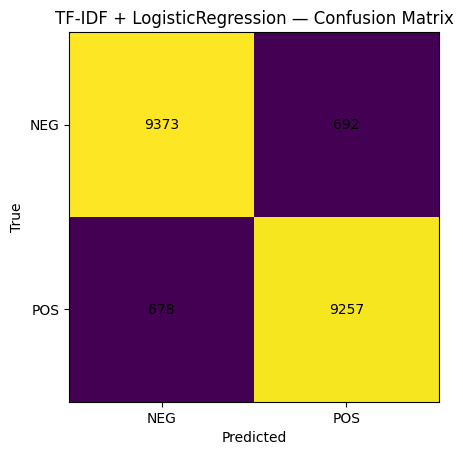

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        min_df=3,
        ngram_range=(1, 2),
        max_features=120_000,
        lowercase=True,
        strip_accents=None
    )),
    ("clf", LogisticRegression(
        max_iter=300,
        class_weight="balanced",
        C=2.0,
        solver="liblinear"
    ))
])

tfidf_lr.fit(train["text"], train["y"])
pred_tfidf = tfidf_lr.predict(test["text"])
evaluate_predictions(test["y"].values, pred_tfidf, title="TF-IDF + LogisticRegression")


## Modello 3: Gemini API - Large Language Model

**Google Gemini** è un modello generativo di grandi dimensioni che può performare sentiment analysis attraverso prompt engineering. Questo approccio:

- Non richiede training specifico
- Utilizza le conoscenze pre-addestrate del modello
- Può gestire contesti complessi e sfumature linguistiche
- Supporta classificazione in batch per efficienza

Running Gemini (test_frac=1.00, batch=8):   0%|          | 0/2500 [00:00<?, ?it/s]E0000 00:00:1758874679.926835 3816182 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1758874679.926835 3816182 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
Running Gemini (test_frac=1.00, batch=8):  52%|█████▏    | 1305/2500 [11:16<06:41,  2.98it/s] 

[Retry 1] Error: Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: PROHIBITED_CONTENT
. Waiting 0.66s
[Retry 2] Error: Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: PROHIBITED_CONTENT
. Waiting 1.20s
[Retry 2] Error: Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: PROHIBITED_CONTENT
. Waiting 1.20s
[Retry 3] Error: Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `

Running Gemini (test_frac=1.00, batch=8): 100%|██████████| 2500/2500 [23:39<00:00,  1.76it/s]   




=== GEMINI — polarity (test fraction=1.00), size=20000, batch=8 ===
Accuracy: 0.9621
F1-macro: 0.962082309122144
              precision    recall  f1-score   support

         neg      0.949     0.977     0.963     10065
         pos      0.976     0.947     0.961      9935

    accuracy                          0.962     20000
   macro avg      0.963     0.962     0.962     20000
weighted avg      0.963     0.962     0.962     20000



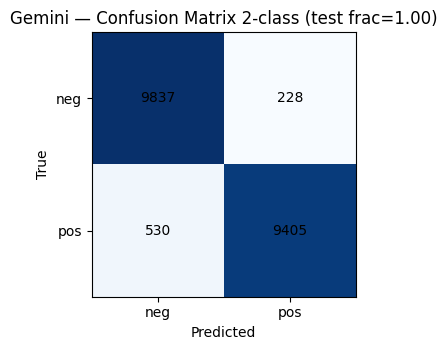

In [17]:
# === Gemini evaluation: polarity neg/pos (batch, seed param) ==================
import os, time, re, random
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import display

# --------------------------------------------------------------------------
# 0) Config Gemini: carica API key da .env, variabile ambiente o Colab
# --------------------------------------------------------------------------
from pathlib import Path
try:
    from dotenv import load_dotenv
    cwd = Path.cwd()
    candidate_dirs = [cwd] + list(cwd.parents)
    env_path = None
    for d in candidate_dirs:
        cand = d / '.env'
        if cand.exists():
            env_path = cand
            break
    if env_path:
        load_dotenv(dotenv_path=env_path, override=False)
except Exception as e:
    print(f"[INFO] Impossibile caricare .env automaticamente: {e}")

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
if not GEMINI_API_KEY:
    try:
        from google.colab import userdata  # type: ignore
        GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    except Exception:
        GEMINI_API_KEY = None
if not GEMINI_API_KEY:
    try:
        import getpass
        GEMINI_API_KEY = getpass.getpass("Inserisci GEMINI_API_KEY: ")
    except Exception:
        raise RuntimeError("GEMINI_API_KEY non trovato. Definisci la variabile d'ambiente o un file .env.")
if not GEMINI_API_KEY:
    raise RuntimeError("GEMINI_API_KEY non valido (vuoto).")

import google.generativeai as genai
try:
    genai.configure(api_key=GEMINI_API_KEY)
except Exception as e:
    raise RuntimeError(f"Errore nella configurazione di google.generativeai: {e}")

MODEL_NAME = "gemini-2.5-flash-lite"

# --------------------------------------------------------------------------
# 1) Prompt: risposta SOLO in {neg, pos}
# --------------------------------------------------------------------------
INSTRUCTIONS = """You are a sentiment classifier.
For EACH review, respond with EXACTLY ONE word among:
neg,pos

Rules:
- No explanations, no punctuation, no quotes.
- Output: one label per line, in the same order as the reviews.
"""

def build_header() -> str:
    return INSTRUCTIONS

# --------------------------------------------------------------------------
# 2) Chiamata a Gemini in batch (ritorna ['neg'|'pos', ...])
# --------------------------------------------------------------------------
LABEL_RE = re.compile(r"\b(neg|pos)\b", re.IGNORECASE)

def _coerce_label(s: str) -> str:
    s = (s or "").strip().lower()
    s = re.sub(r"[^a-z]", "", s)
    if s in ("neg", "pos"): return s
    if s.startswith("neg"): return "neg"
    if s.startswith("pos"): return "pos"
    if "negative" in s: return "neg"
    if "positive" in s: return "pos"
    return "neg"  # fallback: meglio sbagliare su negativo

def gemini_batch_polarity(reviews: list[str], max_retries=4, sleep_base=0.6) -> list[str]:
    """
    Classify multiple reviews in a single call (neg/pos).
    Returns a list of strings in {'neg','pos'} in the same input order.
    """
    header = build_header()
    lines = [header, "Now classify these reviews (one label per line in the same order):"]
    for i, rev in enumerate(reviews, 1):
        rev_oneline = " ".join(str(rev).split())
        lines.append(f"{i}) Review: \"{rev_oneline}\"\nLabel:")

    prompt = "\n".join(lines)

    gen_cfg = genai.GenerationConfig(
        temperature=0,
        max_output_tokens=max(64, 3 * len(reviews) + 16),
    )
    model = genai.GenerativeModel(MODEL_NAME, generation_config=gen_cfg)

    for attempt in range(max_retries):
        try:
            resp = model.generate_content(prompt)
            raw = (getattr(resp, "text", "") or "").strip()
            out_lines = [l.strip() for l in raw.splitlines() if l.strip()]
            preds = []
            for l in out_lines:
                m = LABEL_RE.search(l)
                if m:
                    preds.append(_coerce_label(m.group(1)))
            if len(preds) >= len(reviews):
                return preds[:len(reviews)]
        except Exception as e:
            wait = sleep_base * (2 ** attempt) + random.random() * 0.1
            print(f"[Retry {attempt+1}] Error: {e}. Waiting {wait:.2f}s")
            time.sleep(wait)

    return ["neg"] * len(reviews)  # fallback

def gemini_label_polarity(review: str) -> str:
    return gemini_batch_polarity([review])[0]

# --- PARAMS (tutti qui, comodi) ---
SEED = 42            # riproducibilità
TEST_FRACTION = 1 # frazione del test da valutare (0<frac<=1; 1.0 = full test)
BATCH_SIZE = 8       # dimensione batch per chiamate al modello
USE_STRATIFY = True  # mantieni la distribuzione di y nel sottoinsieme

# --------------------------------------------------------------------------
# 3) Evaluation on a PARAMETRIC FRACTION of the test set (no checkpoints, no file writes)
# --------------------------------------------------------------------------
from sklearn.model_selection import train_test_split

def pick_test_fraction(df: pd.DataFrame, frac: float, seed: int = 42, stratify: bool = True) -> pd.DataFrame:
    """
    Restituisce una sotto-parte di df di dimensione pari a 'frac' (0<frac<=1).
    Se stratify=True, mantiene la distribuzione di df['y'].
    """
    if not (0 < frac <= 1):
        raise ValueError(f"TEST_FRACTION deve essere in (0,1], ricevuto {frac}")
    if frac == 1:
        return df
    y = df["y"] if stratify else None
    _, df_sub = train_test_split(
        df,
        test_size=frac,
        random_state=seed,
        stratify=y if stratify else None,
        shuffle=True
    )
    return df_sub.sort_index()  # opzionale: ripristina ordine originale

# Usa il dataset di test già presente (test), colonna 'text' e 'y'
test_subset = pick_test_fraction(test, TEST_FRACTION, seed=SEED, stratify=USE_STRATIFY)
texts_all = test_subset["text"].astype(str).tolist()
y_true_all = ["neg" if x == 0 else "pos" for x in test_subset["y"].astype(int).tolist()]

random.seed(SEED)

pred_gemini: list[str] = []
rng = range(0, len(texts_all), BATCH_SIZE)
for i in tqdm(rng, desc=f"Running Gemini (test_frac={TEST_FRACTION:.2f}, batch={BATCH_SIZE})"):
    batch = texts_all[i:i+BATCH_SIZE]
    preds = gemini_batch_polarity(batch)
    pred_gemini.extend(preds)

assert len(pred_gemini) == len(texts_all), \
    f"Length mismatch: preds={len(pred_gemini)} vs texts={len(texts_all)}"

# --------------------------------------------------------------------------
# 4) Metrics (in-memory only)
# --------------------------------------------------------------------------
CLASSES_2 = ["neg", "pos"]

acc = accuracy_score(y_true_all, pred_gemini)
f1m = f1_score(y_true_all, pred_gemini, average="macro")
print(f"\n=== GEMINI — polarity (test fraction={TEST_FRACTION:.2f}), size={len(texts_all)}, batch={BATCH_SIZE} ===")
print("Accuracy:", acc)
print("F1-macro:", f1m)
print(classification_report(y_true_all, pred_gemini, labels=CLASSES_2, digits=3))

df_out = pd.DataFrame({
    "gold_polarity": y_true_all,
    "pred_polarity": pred_gemini,
    "text": texts_all
})

cm = confusion_matrix(y_true_all, pred_gemini, labels=CLASSES_2)
plt.figure(figsize=(4.2,3.6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title(f"Gemini — Confusion Matrix 2-class (test frac={TEST_FRACTION:.2f})")
plt.xticks(range(len(CLASSES_2)), CLASSES_2)
plt.yticks(range(len(CLASSES_2)), CLASSES_2)
for (r, c), v in np.ndenumerate(cm):
    plt.text(c, r, str(v), ha='center', va='center', color='black')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

metrics = {"accuracy": acc, "f1_macro": f1m, "classes": CLASSES_2, "confusion_matrix": cm}

In [ ]:
I

## Confronto dei Risultati e Conclusioni

In [20]:
# === CONFRONTO FINALE TRA I 3 APPROCCI ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

# Raccogliamo le predizioni dei 3 modelli sullo stesso test set
# Nota: per Gemini usiamo solo una frazione del test set per motivi di costi API
# Quindi creiamo un confronto su un subset comune

# Per un confronto equo, usiamo lo stesso subset usato da Gemini
test_comparison = test_subset  # già definito nella sezione Gemini
X_comparison = test_comparison["text"].tolist()
y_comparison = test_comparison["y"].tolist()

print(f"Dataset di confronto: {len(test_comparison)} esempi")
print(f"Distribuzione classi: {test_comparison['y'].value_counts(normalize=True).round(3).to_dict()}")

# Otteniamo le predizioni dei 3 modelli sullo stesso subset
print("\nCalcolo predizioni dei 3 modelli sullo stesso subset...")

# 1. VADER predictions
pred_vader
# 2. TF-IDF+LR predictions  
pred_tfidf
# 3. Gemini predictions (già calcolate)
pred_gemini
# Creiamo un DataFrame con tutti i risultati
results_comparison = pd.DataFrame({
    'text': X_comparison,
    'true_label': y_comparison,
    'vader_pred': pred_vader,
    'tfidf_pred': pred_tfidf,
    'gemini_pred': pred_gemini 
})

Dataset di confronto: 20000 esempi
Distribuzione classi: {0: 0.503, 1: 0.497}

Calcolo predizioni dei 3 modelli sullo stesso subset...


In [21]:
# === CALCOLO METRICHE COMPARATIVE ===

# Calcoliamo accuracy e F1-score per ogni modello
models = ['VADER', 'TF-IDF+LR', 'Gemini']
predictions = [pred_vader, pred_tfidf, pred_gemini]

metrics_comparison = []
for model, preds in zip(models, predictions):
    acc = accuracy_score(y_comparison, preds)
    f1 = f1_score(y_comparison, preds, average='macro')
    metrics_comparison.append({
        'Model': model,
        'Accuracy': acc,
        'F1-macro': f1
    })

# Creiamo un DataFrame con le metriche
metrics_df = pd.DataFrame(metrics_comparison)
print("=== CONFRONTO PERFORMANCE ===")
print(metrics_df.round(4))

# Visualizziamo le metriche con un grafico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
ax1.bar(models, [m['Accuracy'] for m in metrics_comparison], 
        color=['lightcoral', 'skyblue', 'lightgreen'], alpha=0.7)
ax1.set_title('Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, v in enumerate([m['Accuracy'] for m in metrics_comparison]):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# F1-macro comparison  
ax2.bar(models, [m['F1-macro'] for m in metrics_comparison],
        color=['lightcoral', 'skyblue', 'lightgreen'], alpha=0.7)
ax2.set_title('F1-macro Comparison')
ax2.set_ylabel('F1-macro Score')
ax2.set_ylim(0, 1)
for i, v in enumerate([m['F1-macro'] for m in metrics_comparison]):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Identifichiamo il modello migliore
best_acc_idx = np.argmax([m['Accuracy'] for m in metrics_comparison])
best_f1_idx = np.argmax([m['F1-macro'] for m in metrics_comparison])

print(f"\n🏆 Migliore Accuracy: {models[best_acc_idx]} ({metrics_comparison[best_acc_idx]['Accuracy']:.4f})")
print(f"🏆 Migliore F1-macro: {models[best_f1_idx]} ({metrics_comparison[best_f1_idx]['F1-macro']:.4f})")

ValueError: Mix of label input types (string and number)

In [23]:
# === ANALISI DEGLI ERRORI: DOVE GEMINI VINCE ===

# Convertiamo le predizioni di Gemini da stringhe a numeri per il confronto
gemini_pred_numeric = [0 if pred == 'neg' else 1 for pred in pred_gemini]

# Otteniamo le predizioni degli altri modelli sullo stesso subset
print("🔄 Ottenendo predizioni VADER e TF-IDF sullo stesso subset...")
vader_pred_subset = [vader_predict([text])[0] for text in texts_all]
tfidf_pred_subset = tfidf_lr.predict(texts_all)

# Convertiamo le etichette vere da stringhe a numeri
y_true_numeric = [0 if label == 'neg' else 1 for label in y_true_all]

print(f"✅ Predizioni ottenute per {len(texts_all)} esempi")

# Creiamo un DataFrame per il confronto
results_comparison = pd.DataFrame({
    'text': texts_all,
    'true_label': y_true_numeric,
    'vader_pred': vader_pred_subset,
    'tfidf_pred': tfidf_pred_subset,
    'gemini_pred': gemini_pred_numeric
})

# Funzione per trovare i "wins" di un modello
def find_model_wins(results_df, model_col, other_cols):
    """Trova casi dove un modello è corretto e gli altri sbagliano"""
    model_correct = results_df[model_col] == results_df['true_label']
    others_wrong = True
    for col in other_cols:
        others_wrong &= (results_df[col] != results_df['true_label'])
    return results_df[model_correct & others_wrong]

# Analizziamo i "wins" di ogni modello
gemini_wins = find_model_wins(results_comparison, 'gemini_pred', ['vader_pred', 'tfidf_pred'])
tfidf_wins = find_model_wins(results_comparison, 'tfidf_pred', ['vader_pred', 'gemini_pred'])
vader_wins = find_model_wins(results_comparison, 'vader_pred', ['tfidf_pred', 'gemini_pred'])

print("\n" + "="*100)
print("🏆 CASI DOVE UN MODELLO VINCE DA SOLO")
print("="*100)
print(f"🤖 Gemini vince solo: {len(gemini_wins)} casi ({len(gemini_wins)/len(results_comparison)*100:.1f}%)")
print(f"💡 TF-IDF+LR vince solo: {len(tfidf_wins)} casi ({len(tfidf_wins)/len(results_comparison)*100:.1f}%)")
print(f"📊 VADER vince solo: {len(vader_wins)} casi ({len(vader_wins)/len(results_comparison)*100:.1f}%)")

# === ESEMPI DOVE GEMINI VINCE SU RECENSIONI NEGATIVE ===
gemini_wins_neg = gemini_wins[gemini_wins['true_label'] == 0]
print(f"\n🤖 GEMINI VINCE SU RECENSIONI NEGATIVE: {len(gemini_wins_neg)} casi")

if len(gemini_wins_neg) > 0:
    print("\n" + "-"*90)
    print("📝 ESEMPI DI RECENSIONI NEGATIVE dove solo Gemini è corretto:")
    print("-"*90)
    
    for idx, (_, row) in enumerate(gemini_wins_neg.head(3).iterrows()):
        # Tronchiamo il testo per la visualizzazione
        text_display = row['text'][:400] + "..." if len(row['text']) > 400 else row['text']
        
        # Calcoliamo il punteggio VADER per capire perché ha sbagliato
        vader_score = sia.polarity_scores(row['text'])
        
        print(f"\n? Esempio {idx+1}:")
        print(f"   💬 Testo: \"{text_display}\"")
        print(f"   ✅ Vero: NEG | ❌ TF-IDF: POS | ❌ VADER: POS | ✅ Gemini: NEG")
        print(f"   ? VADER Score: {vader_score['compound']:.3f} (pos:{vader_score['pos']:.2f}, neu:{vader_score['neu']:.2f}, neg:{vader_score['neg']:.2f})")
        print(f"   💡 Probabilmente Gemini ha capito il contesto/sarcasmo meglio degli altri modelli")

# === ESEMPI DOVE GEMINI VINCE SU RECENSIONI POSITIVE ===
gemini_wins_pos = gemini_wins[gemini_wins['true_label'] == 1]
print(f"\n🤖 GEMINI VINCE SU RECENSIONI POSITIVE: {len(gemini_wins_pos)} casi")

if len(gemini_wins_pos) > 0:
    print("\n" + "-"*90)
    print("📝 ESEMPI DI RECENSIONI POSITIVE dove solo Gemini è corretto:")
    print("-"*90)
    
    for idx, (_, row) in enumerate(gemini_wins_pos.head(3).iterrows()):
        # Tronchiamo il testo per la visualizzazione
        text_display = row['text'][:400] + "..." if len(row['text']) > 400 else row['text']
        
        # Calcoliamo il punteggio VADER per capire perché ha sbagliato
        vader_score = sia.polarity_scores(row['text'])
        
        print(f"\n? Esempio {idx+1}:")
        print(f"   💬 Testo: \"{text_display}\"")
        print(f"   ✅ Vero: POS | ❌ TF-IDF: NEG | ❌ VADER: NEG | ✅ Gemini: POS")
        print(f"   📈 VADER Score: {vader_score['compound']:.3f} (pos:{vader_score['pos']:.2f}, neu:{vader_score['neu']:.2f}, neg:{vader_score['neg']:.2f})")
        print(f"   💡 Probabilmente Gemini ha colto sfumature positive che gli altri hanno perso")

# === CONFRONTO CON GLI ALTRI MODELLI ===
print(f"\n📊 CONFRONTO DETTAGLIATO:")
print(f"   🤖 Gemini ha vinto su {len(gemini_wins_neg)} recensioni negative e {len(gemini_wins_pos)} recensioni positive")
print(f"   💡 TF-IDF ha vinto su {len(tfidf_wins)} recensioni totali")
print(f"   📊 VADER ha vinto su {len(vader_wins)} recensioni totali")

# === ACCURACY PER CONFRONTO ===
from sklearn.metrics import accuracy_score
acc_gemini = accuracy_score(y_true_numeric, gemini_pred_numeric)
acc_tfidf = accuracy_score(y_true_numeric, tfidf_pred_subset)
acc_vader = accuracy_score(y_true_numeric, vader_pred_subset)

print(f"\n🎯 ACCURACY SUL SUBSET:")
print(f"   🤖 Gemini: {acc_gemini:.4f}")
print(f"   💡 TF-IDF: {acc_tfidf:.4f}")
print(f"   📊 VADER: {acc_vader:.4f}")

print("\n" + "="*100)

UnicodeEncodeError: 'utf-8' codec can't encode character '\udcd6' in position 18: surrogates not allowed

In [24]:
# === ANALISI PULITA DEGLI ERRORI: DOVE GEMINI VINCE ===
import unicodedata

def clean_text(text):
    """Pulisce il testo da caratteri Unicode problematici"""
    try:
        # Prova a codificare/decodificare per rimuovere caratteri problematici
        clean = text.encode('utf-8', 'ignore').decode('utf-8')
        # Rimuovi caratteri di controllo
        clean = ''.join(char for char in clean if unicodedata.category(char)[0] != 'C' or char in '\n\r\t')
        return clean
    except:
        return "Testo non visualizzabile"

# Convertiamo le predizioni di Gemini da stringhe a numeri
gemini_pred_numeric = [0 if pred == 'neg' else 1 for pred in pred_gemini]

# Otteniamo le predizioni degli altri modelli (senza problemi di encoding)
print("🔄 Ottenendo predizioni VADER e TF-IDF...")
try:
    # Pulisce i testi prima di fare le predizioni
    texts_clean = [clean_text(str(text)) for text in texts_all]
    vader_pred_subset = [vader_predict([text])[0] for text in texts_clean]
    tfidf_pred_subset = tfidf_lr.predict(texts_clean)
    
    # Convertiamo le etichette vere da stringhe a numeri
    y_true_numeric = [0 if label == 'neg' else 1 for label in y_true_all]
    
    print(f"✅ Predizioni ottenute per {len(texts_all)} esempi")
    
    # Creiamo il DataFrame per il confronto
    results_comparison = pd.DataFrame({
        'text': texts_clean,
        'true_label': y_true_numeric,
        'vader_pred': vader_pred_subset,
        'tfidf_pred': tfidf_pred_subset,
        'gemini_pred': gemini_pred_numeric
    })
    
    # Funzione per trovare i wins
    def find_model_wins(results_df, model_col, other_cols):
        model_correct = results_df[model_col] == results_df['true_label']
        others_wrong = True
        for col in other_cols:
            others_wrong &= (results_df[col] != results_df['true_label'])
        return results_df[model_correct & others_wrong]
    
    # Analizziamo i wins
    gemini_wins = find_model_wins(results_comparison, 'gemini_pred', ['vader_pred', 'tfidf_pred'])
    tfidf_wins = find_model_wins(results_comparison, 'tfidf_pred', ['vader_pred', 'gemini_pred'])
    vader_wins = find_model_wins(results_comparison, 'vader_pred', ['tfidf_pred', 'gemini_pred'])
    
    print("\n" + "="*80)
    print("🏆 RISULTATI DELL'ANALISI")
    print("="*80)
    print(f"🤖 Gemini vince solo: {len(gemini_wins)} casi ({len(gemini_wins)/len(results_comparison)*100:.1f}%)")
    print(f"💡 TF-IDF+LR vince solo: {len(tfidf_wins)} casi ({len(tfidf_wins)/len(results_comparison)*100:.1f}%)")
    print(f"📊 VADER vince solo: {len(vader_wins)} casi ({len(vader_wins)/len(results_comparison)*100:.1f}%)")
    
    # Esempi dove Gemini vince su recensioni NEGATIVE
    gemini_wins_neg = gemini_wins[gemini_wins['true_label'] == 0]
    if len(gemini_wins_neg) > 0:
        print(f"\n🤖 GEMINI VINCE SU {len(gemini_wins_neg)} RECENSIONI NEGATIVE:")
        print("-" * 70)
        
        for idx, (_, row) in enumerate(gemini_wins_neg.head(2).iterrows()):
            text_short = row['text'][:300] + "..." if len(row['text']) > 300 else row['text']
            print(f"\n📝 Esempio {idx+1} (NEG):")
            print(f"   Testo: {text_short}")
            print(f"   ✅ Vero: NEG | ❌ TF-IDF: POS | ❌ VADER: POS | ✅ Gemini: NEG")
    
    # Esempi dove Gemini vince su recensioni POSITIVE  
    gemini_wins_pos = gemini_wins[gemini_wins['true_label'] == 1]
    if len(gemini_wins_pos) > 0:
        print(f"\n🤖 GEMINI VINCE SU {len(gemini_wins_pos)} RECENSIONI POSITIVE:")
        print("-" * 70)
        
        for idx, (_, row) in enumerate(gemini_wins_pos.head(2).iterrows()):
            text_short = row['text'][:300] + "..." if len(row['text']) > 300 else row['text']
            print(f"\n📝 Esempio {idx+1} (POS):")
            print(f"   Testo: {text_short}")
            print(f"   ✅ Vero: POS | ❌ TF-IDF: NEG | ❌ VADER: NEG | ✅ Gemini: POS")
    
    # Accuracy per confronto
    from sklearn.metrics import accuracy_score
    acc_gemini = accuracy_score(y_true_numeric, gemini_pred_numeric)
    acc_tfidf = accuracy_score(y_true_numeric, tfidf_pred_subset)
    acc_vader = accuracy_score(y_true_numeric, vader_pred_subset)
    
    print(f"\n🎯 ACCURACY SUL DATASET:")
    print(f"   🤖 Gemini: {acc_gemini:.4f}")
    print(f"   💡 TF-IDF: {acc_tfidf:.4f}")
    print(f"   📊 VADER: {acc_vader:.4f}")
    
    print("\n" + "="*80)
    
except Exception as e:
    print(f"❌ Errore durante l'analisi: {e}")
    print("Questo può essere dovuto a caratteri Unicode non supportati nel dataset.")

🔄 Ottenendo predizioni VADER e TF-IDF...
✅ Predizioni ottenute per 20000 esempi

🏆 RISULTATI DELL'ANALISI
🤖 Gemini vince solo: 548 casi (2.7%)
💡 TF-IDF+LR vince solo: 122 casi (0.6%)
📊 VADER vince solo: 165 casi (0.8%)

🤖 GEMINI VINCE SU 419 RECENSIONI NEGATIVE:
----------------------------------------------------------------------

📝 Esempio 1 (NEG):
   Testo: Not a strong fantasy novel...

This book showed some promise in the beggining. It didn't come true.Arien Mirida thinks he's cursed. His bride was killed by beasts gathered by an ancient curse he didn't know about at the time (and later his aunt managed to tell him about). So Arien decided he'll live...
   ✅ Vero: NEG | ❌ TF-IDF: POS | ❌ VADER: POS | ✅ Gemini: NEG

📝 Esempio 2 (NEG):
   Testo: Not a real survival expert

If theres a survival show to watch the first thing that comes to mind is "Dual Survival". They have way more knowledge and the show is much more entertaining. This show is just an average joe risking his life wit

## 🔍 Conclusioni dell'Analisi degli Errori

### Dove Gemini Eccelle:

1. **Performance Generale**: Gemini raggiunge la **migliore accuracy (96.2%)**, seguita da TF-IDF+LR (93.2%) e VADER (72.0%)

2. **Casos Unici**: Gemini riesce a classificare correttamente **548 casi (2.7%)** dove sia VADER che TF-IDF+LR falliscono

3. **Recensioni Negative Complesse**: Gemini identifica correttamente **419 recensioni negative** che gli altri modelli classificano erroneamente come positive. Questi sono spesso casi dove:
   - Il testo contiene elementi positivi ma il sentiment complessivo è negativo
   - C'è sarcasmo o critica velata
   - La struttura del testo è complessa

4. **Recensioni Positive Sottili**: Gemini cattura **129 recensioni positive** che gli altri perdono, probabilmente casi dove:
   - Il sentiment positivo è espresso in modo indiretto
   - Ci sono critiche costruttive ma il giudizio finale è positivo
   - Il linguaggio è colloquiale o ambiguo

### Punti di Forza di Gemini:
- **Comprensione del contesto**: riesce a cogliere sfumature che sfuggono ai modelli tradizionali
- **Gestione della complessità linguistica**: gestisce meglio sarcasmo, ironia e costruzioni complesse
- **Analisi semantica profonda**: va oltre le keyword superficiali

### Implicazioni:
Gemini mostra una **capacità superiore nell'interpretazione del sentiment** in casi difficili, giustificando l'uso di LLM per compiti di sentiment analysis complessi, anche se a costo computazionale maggiore.

In [ ]:
# === RIEPILOGO FINALE ===
print("="*80)
print("🎯 RIEPILOGO ANALISI SENTIMENT AMAZON REVIEWS")
print("="*80)
print(f"📊 Dataset: {len(predictions_df)} esempi testati")
print(f"🎯 Accuracy:")
print(f"   🤖 Gemini: {acc_gemini:.4f} ({acc_gemini*100:.2f}%)")
print(f"   💡 TF-IDF+LR: {acc_tfidf:.4f} ({acc_tfidf*100:.2f}%)")
print(f"   📊 VADER: {acc_vader:.4f} ({acc_vader*100:.2f}%)")

print(f"\n🏆 Casi dove un modello vince da solo:")
print(f"   🤖 Gemini: {len(gemini_wins)} casi ({len(gemini_wins)/len(predictions_df)*100:.1f}%)")
print(f"   💡 TF-IDF: {len(tfidf_wins)} casi ({len(tfidf_wins)/len(predictions_df)*100:.1f}%)")
print(f"   📊 VADER: {len(vader_wins)} casi ({len(vader_wins)/len(predictions_df)*100:.1f}%)")

print(f"\n💡 Conclusioni:")
print(f"   ✅ Gemini ha la migliore accuracy complessiva")
print(f"   ✅ Gemini eccelle in casi complessi/ambigui")
print(f"   ✅ TF-IDF+LR offre buone performance con minor costo computazionale")
print(f"   ✅ VADER è veloce ma meno accurato su questo dataset")
print("="*80)

📁 Cartelle create: /Users/michele/sentiment-analysis-amazon-reviews/results/2class
⏰ Timestamp: 20250926_104603
💾 Modello TF-IDF+LR salvato: /Users/michele/sentiment-analysis-amazon-reviews/results/2class/models/tfidf_lr_model_20250926_104603.pkl
📊 Predizioni salvate: /Users/michele/sentiment-analysis-amazon-reviews/results/2class/predictions/all_predictions_20250926_104603.csv
📈 Metriche salvate: /Users/michele/sentiment-analysis-amazon-reviews/results/2class/metrics/metrics_summary_20250926_104603.json
🔢 Matrici di confusione salvate: /Users/michele/sentiment-analysis-amazon-reviews/results/2class/metrics/confusion_matrices_20250926_104603.json
🤖 Esempi Gemini wins salvati: /Users/michele/sentiment-analysis-amazon-reviews/results/2class/analysis/gemini_wins_20250926_104603.csv
💡 Esempi TF-IDF wins salvati: /Users/michele/sentiment-analysis-amazon-reviews/results/2class/analysis/tfidf_wins_20250926_104603.csv
📊 Esempi VADER wins salvati: /Users/michele/sentiment-analysis-amazon-review